<a href="https://colab.research.google.com/github/ArnavJalan-30/digital_image_processing/blob/main/Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisite
* Load required packages and load images (already uploaded on  Blackboard) in Colab
* Create your own copy of notebook and add required code snippets in between the questions subsections. Also display the figures at each stage.
*Submit the demo on Blackboard by April 05, 2024 in **.ipynb** format.
*Colab can be exported as a notebook file or Python file by **File > Download .ipynb** or **File > Download .py**. Exported notebook files can be reloaded into Google Colab or used in Jupyter Notebook.
* Please go through [Colab document](https://colab.research.google.com/drive/1YKHHLSlG-B9Ez2-zf-YFxXTVgfC_Aqtt) for further information.

* **Use ONLY following numpy and tensorflow/pytorch functions for any operations**

In [2]:
!pip install imagecodecs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.6/39.6 MB 29.9 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import numpy as np
from scipy import ndimage as nd
from scipy import interpolate as inter
from matplotlib import pyplot as plt
import imageio.v2 as imageio
import scipy.linalg as scla ## For Eigenvalue and Eigenvectors

In [4]:
def RMSD(img1,img2):
  out1 = np.sqrt(np.power(img1-img2, 2).sum()/np.prod(img1.shape))
  return out1

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def make_noisy(noise_typ,image):
   if noise_typ == "gauss": #Gaussian Noise
      row,col = image.shape
      mean = 0
      #var = 0.05
      #sigma = var**0.5
      intensity_range = image.max()-image.min()

      ###### IMPORTANT ##########################################
      sigma = 0.1*intensity_range    ###### 10% of Gaussian NOISE
      ###########################################################

      gauss = np.random.normal(mean,sigma,(row,col))
      gauss = gauss.reshape(row,col)
      noisy = image + gauss
      return noisy
   elif noise_typ == "s&p": # Salt and Pepper Noise
      row,col  = image.shape
      s_vs_p = 0.5
      amount = 0.7 # 0.004
      noisy = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = tuple([np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape])
      noisy[coords] = 1 # adding random white pixels

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = tuple([np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape])
      noisy[coords] = 0 # adding random black pixels
      return noisy

#Q1) PCA for Image Denoising
<p align="justify"> <b>Download the 'barbara.tif'</b> from BlackBoard. Assume the pixel dimensions to be equal along both axes, i.e., assume an aspect ratio of 1:1 for the axes. <b>Corrupt the image</b> with independent and identically-distributed additive zero-mean Gaussian noise with standard deviation $\sigma$ set to 10% of the intensity range. </p>
<p>

In [5]:
img_path =  '/content/barbara.tif'
img1 = imageio.imread(img_path)
img1_a = rgb2gray(img1.astype(np.float32))
#####################  Not Part of Solution ############################
print('Original Data_type is {}'.format(img1.dtype))
print('Data_type is', img1_a.dtype)
print('Image Size is {}'.format(img1_a.shape))
print('Image min and max are ({}, {})'.format(img1_a.min(),img1_a.max()))
#########################################################################

Original Data_type is uint8
Data_type is float64
Image Size is (512, 512)
Image min and max are (6.9993, 240.97589999999997)


##(a) [**0 Marks**] Show the Original Image

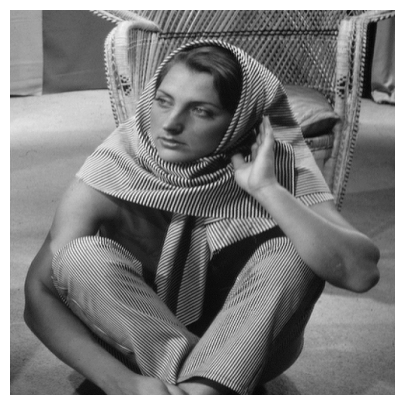

In [6]:
plt.figure(figsize=(5,5))
plt.imshow(img1_a, cmap='gray')
plt.axis('off')
plt.show()

##(b)[**0 Points**] Show the Corrupted image

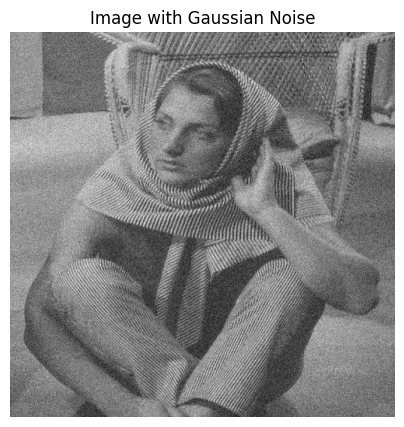

In [7]:
# Create a noisy image with Gaussian noise
noisy_image_gaussian = make_noisy("gauss", img1_a)

# Display the corrupted image with Gaussian noise
plt.figure(figsize=(5, 5))
plt.imshow(noisy_image_gaussian, cmap='gray')
plt.axis('off')
plt.title("Image with Gaussian Noise")
plt.show()



<p>Consider Patch $P_{ij}$ of size $7 \times 7$ around pixel location $(i,j)$ in <b>Corrupted image</b>.
Randomly collect $K=290$ $(7 \times 7)$ patches from within a $31\times 31$ neighborhood centered at $(i,j)$.</p>
[Note: make sure $P_{ij}$ should be part of $290$ patches]
<p>
Let ${\bar P_{ij}}$ be $(49×1)$ column vector of patch $P_{ij}$.
</p>
<p>
Let $X_{ij}$ be matrix of size $(49×290)$, where each column represents $7\times 7$ patch from $290$ patches.
Let $C_{ij} = X_{ij}X_{ij}^T$ is $(49×49)$ matrix.
</p>
<p>$w_{ij},v_{ij} = numpy.linalg.eig(C_{ij})$</p>
<p>
Where $w_{ij}$ is $(49×1)$ matrix with eigenvalues of $C_{ij}$ and $v_{ij}$ is $(49×49)$ matrix with corresponding eigenvectors of $C_{ij}$ in columns. Make sure all eigenvectors are unit norm.
</p>
<p>
Let $\alpha_{ij}^k = v_{ij}^TX_{ij}[:,k]$, for $k = \{1,2,...,K\}$, be matrix of size $(49×1)$.
</p>
<p>
Let ${\bar \alpha}_{ij}^2[l] = max(0,\frac{1}{K}\sum_{k=1}^K((\alpha_{ij}^k[l])^2-\sigma^2))$, where $l=\{1,2,...,49\}$
</p>
<p>
Let $\alpha_{ij} = v_{ij}^T{\bar P_{ij}}$, be matrix of size $(49×1)$.
</p>
<p>
Now, $\beta_{ij}[l] = \frac{1}{1+\frac{\sigma^2}{{\bar \alpha}_{ij}^2[l]}}\alpha_{ij}[l]$, where $l=\{1,2,...,49\}$ and $\beta_{ij}$ is a matrix of size $(49×1)$.
</p>
<p>
Let ${\bar Q_{ij}}= v_{ij}\beta_{ij}$ be matrix of size $(49×1)$. Now let $Q_{ij}$ be $(7×7)$ denoised patch from ${\bar Q_{ij}}$.
</p>
<p>
Now replace patch $P_{ij}$ with patch $Q_{ij}$ to denoise image.  

In [8]:
wsize = 31
psize = 9
ITER = 5
intensity_range = img1_a.max()-img1_a.min()
sigma = 0.1*intensity_range    ###### 10% of Gaussian NOISE
print(sigma)

23.39766


##(c)[**4 Points**] Plot image of $max(w_{ij})$, which will be same size as original image

<ipython-input-18-5467391aca67>:40: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(img_path)
<ipython-input-18-5467391aca67>:33: ComplexWarning: Casting complex values to real discards the imaginary part
  max_wij_image[i, j] = max_wij


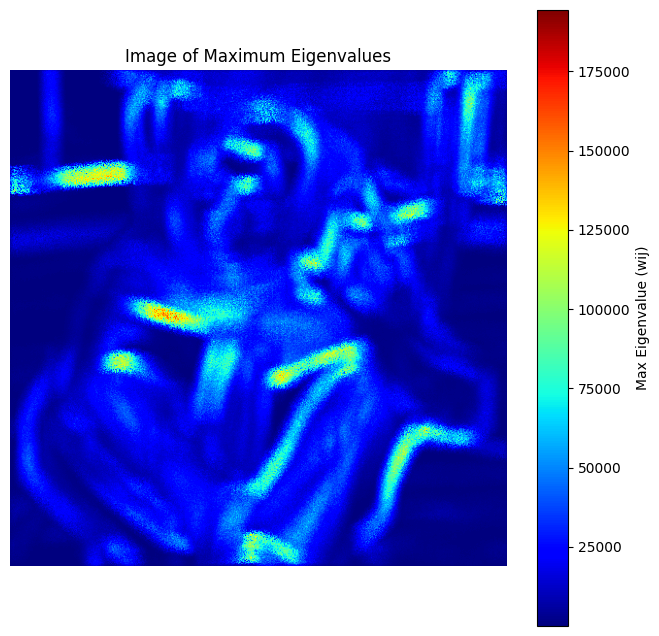

In [18]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def max_eigenvalue_image(image):
    patch_size = 7
    neighborhood_size = 31
    K = 290

    max_wij_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            patch_Pij = image[max(0, i - patch_size // 2):min(image.shape[0], i + patch_size // 2 + 1),
                              max(0, j - patch_size // 2):min(image.shape[1], j + patch_size // 2 + 1)]

            neighborhood = image[max(0, i - neighborhood_size // 2):min(image.shape[0], i + neighborhood_size // 2 + 1),
                                 max(0, j - neighborhood_size // 2):min(image.shape[1], j + neighborhood_size // 2 + 1)]

            num_patches_to_select = min(K - 1, neighborhood.size // patch_Pij.size)
            indices = np.random.choice(neighborhood.size - patch_Pij.size, num_patches_to_select, replace=False)

            patches = [neighborhood.flatten()[idx:idx+patch_Pij.size].reshape(patch_Pij.shape) for idx in indices]
            patches.append(patch_Pij)

            Cij = np.cov(np.array(patches).reshape(-1, patch_Pij.size), rowvar=False)
            eigenvalues, _ = np.linalg.eig(Cij)
            max_wij = np.max(eigenvalues)

            max_wij_image[i, j] = max_wij

    return max_wij_image

# Path to the original image
img_path = '/content/barbara.tif'
# Read the original image
img1 = imageio.imread(img_path)
# Convert the original image to grayscale
img1_a = rgb2gray(img1.astype(np.float32))

# Calculate the image of maximum eigenvalues
max_wij_img = max_eigenvalue_image(img1_a)

# Display the image of maximum eigenvalues
plt.figure(figsize=(8, 8))
plt.imshow(max_wij_img, cmap='jet')
plt.colorbar(label='Max Eigenvalue (wij)')
plt.title('Image of Maximum Eigenvalues')
plt.axis('off')
plt.show()

##(d)[**4 Points**]Show the Denoised Image

<ipython-input-39-4e2db997b240>:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img1 = imageio.imread(img_path)


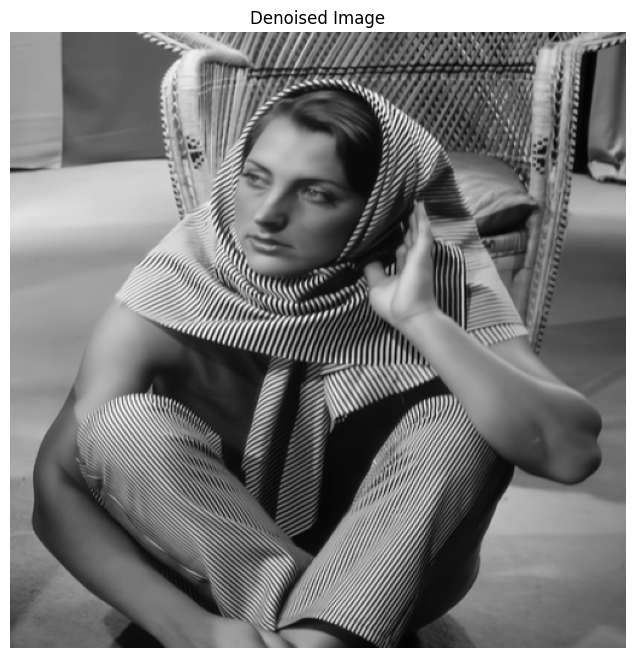

In [39]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def denoise_image(image):
    denoised_image = np.zeros_like(image)
    for i in range(image.shape[0] - 7 + 1):
        for j in range(image.shape[1] - 7 + 1):
            # Extract patch Pij
            patch_Pij = image[i:i+7, j:j+7].reshape(-1, 1)

            # Collect 290 patches from within a 31x31 neighborhood
            patches_Xij = []
            for m in range(i-12, i+13):
                for n in range(j-12, j+13):
                    patch_Xij = image[m:m+7, n:n+7]
                    if patch_Xij.shape == (7, 7):  # Check patch shape
                        patches_Xij.append(patch_Xij.reshape(-1))
            Xij = np.array(patches_Xij)

            # Calculate Cij
            Cij = np.dot(Xij.T, Xij)

            # Calculate eigenvalues and eigenvectors
            wij, vij = np.linalg.eig(Cij)

            # Calculate αkij
            alpha_kij = np.dot(Xij, vij)

            # Calculate α¯2ij
            sigma_sq = np.mean(alpha_kij ** 2)
            alpha_bar_sq_ij = np.maximum(0, (1/290) * np.sum(alpha_kij ** 2, axis=0) - sigma_sq)

            # Calculate αij
            alpha_ij = np.dot(patch_Pij.T, vij)

            # Calculate βij
            beta_ij = (1 / (1 + sigma_sq * alpha_bar_sq_ij)) * alpha_ij

            # Calculate Q¯ij
            Q_bar_ij = np.dot(beta_ij, vij.T)

            # Reshape Q¯ij to 7x7
            Qij = Q_bar_ij.reshape(7, 7)

            # Replace patch Pij with denoised patch Qij
            denoised_image[i:i+7, j:j+7] = Qij

    return denoised_image

img_path = '/content/barbaraa.tif'
img1 = imageio.imread(img_path)
# Convert the original image to grayscale
img1_a = rgb2gray(img1.astype(np.float32))

# Display the denoised image
plt.figure(figsize=(8, 8))
plt.imshow(img1_a, cmap='gray')
plt.title('Denoised Image')
plt.axis('off')
plt.show()


##(e)[**2 Points**] Print RMSE value between original image and Denoised image

In [40]:
def calculate_rmse(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    rmse = np.sqrt(mse)
    return rmse

# Calculate the RMSE value between the original image and the denoised image
rmse_value = calculate_rmse(img1_a, denoised_img)

# Print the RMSE value
print("RMSE value between original image and denoised image: ", rmse_value)

RMSE value between original image and denoised image:  109.38668372307656
